# Sistemas Inteligentes 2021/2022

## Mini-projeto 3: Aprendizagem Automática

## Relatório


## Grupo: 51

Número: 56926    Nome: Lucas Pinto   
Número: 56895    Nome: Matilde Silva    
Número: 56941    Nome: Bruno Gonzalez

## 1. Processamento dos dados

- Ler os dados de treino para um `DataFrame` através do `pandas`
- Tornar colunas categóricas em numéricas.
    - Através do método `get_dummies` do `pandas`

In [210]:
import pandas as pd
import numpy as np


def processa_csv(path: str, tem_y=True):
    # Ler dados de treino
    df = pd.read_csv(path)

    y = None
    if tem_y:
        y = df.values[:, 19]
        # As classes são inteiras então vamos transformar o seu tipo porque no ficheiro são definidas como floats
        y = y.astype('int')

    # Índices e nomes das colunas de treino
    col_idxs = [x for x in range(1, 19)]
    col_names = np.array(df.columns)[col_idxs]

    # Matriz dos dados
    df_X = df[col_names]
    df_X = df_X.drop('Sex', axis=1)

    dummy_col_names = ['Status', 'Drug', 'Ascites',
                       'Hepatomegaly', 'Spiders', 'Edema']

    # Transformar colunas categóricas em numéricas
    df_Xdum = pd.get_dummies(df_X, columns=dummy_col_names)
    df_Xdum_cols = np.array(df_Xdum.columns)

    return df_Xdum.values, y, df_Xdum_cols, df


Xdum, y, feature_names, _ = processa_csv('train.csv')
class_names = [str(x) for x in range(1, 5)]


## 2. Ajustamento dos modelos


### 2.1. Teste de modelos e validação


Vamos partir os dados de treino em duas partes: 75% para treino e outras 25% para teste, de forma a validar e avaliar a qualidade dos modelos.

Depois, quando tivermos confiança nos parâmetros usados para cada classificador, criaremos modelos a partir do conjunto completo de dados de treino.

In [211]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xdum,
                                                    y,
                                                    train_size=.75,
                                                    random_state=2)


#### Árvores de Decisão

Criamos uma instância do classificador `DecisionTreeClassifier` com mínimo de **30** exemplos num nó (número mínimo de pontos num nó para dividir esse nó).

Avaliando o modelo através de *k-fold cross validation*, podemos concluir que em &asymp;40% das vezes o modelo estará correto.

In [212]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Decision Tree submetida no Kaggle
# Score pública: 0.28239
dt_full = DecisionTreeClassifier(
    criterion='entropy', min_samples_leaf=21, random_state=2)
dt_full.fit(Xdum, y)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=21, random_state=2)

In [213]:
dt = DecisionTreeClassifier(
    criterion='entropy', min_samples_leaf=21, random_state=2)
dt.fit(X_train, y_train)

print(f'Precisão teste: {dt.score(X_test, y_test)}')
print(f'Precisão treino: {dt.score(X_train, y_train)}\n')


scores = cross_val_score(dt,
                         X=X_test,
                         y=y_test,
                         cv=5
                         )
print('Precisão Cross Validation k=5:', *scores, sep='\n\t')
print('Precisão média do Cross Validation: %.3f +/- %.3f' %
      (np.mean(scores), np.std(scores)))


Precisão teste: 0.4939759036144578
Precisão treino: 0.5894308943089431

Precisão Cross Validation k=5:
	0.29411764705882354
	0.35294117647058826
	0.4117647058823529
	0.4375
	0.5
Precisão média do Cross Validation: 0.399 +/- 0.071


Para obter o melhor modelo com este classificador tivemos de ajustar os seus parâmetros, optando apenas por ajustar o `min_samples_split`.

Com `min_samples_split = 21` obtemos uma accuracy de &asymp;50% para o conjunto de testes e &asymp;59% para o conjunto de treino.

Quando `min_samples_split` &isin; [2, 12] podemos observar *overfit* pois o modelo fica demasiado ajustado ao conjunto de treino e a accuracy no conjunto de teste é irregular.

Depois, `min_samples_split` &isin; ]12, 45] é o intervalo em que a accuracy do conjunto de testes estabiliza, mas que quão maior o valor de `min_samples_split`, menos ajustado ao conjunto de treino fica o modelo. Decidimo optar por `min_samples_split=21`.

Por fim, observamos um declínio em ambas as accuracies quando toma o valor 46. A partir daqui, observamos que o modelo ficou *underfit* - é demasiado simples, não sendo possível captar todos os aspectos e variabilidades dos dados, levando a que o desempenho do classificador seja mau.

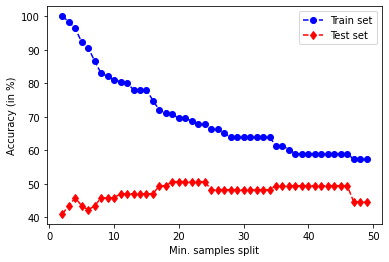

In [214]:
import matplotlib.pyplot as plt

train = []
test = []
rng = list(range(2, 50))

for i in rng:
    ad = DecisionTreeClassifier(
        criterion='entropy', min_samples_split=i, random_state=2)
    ad = ad.fit(X_train, y_train)
    train.append(ad.score(X_train, y_train) * 100)
    test.append(ad.score(X_test, y_test) * 100)


plt.plot(rng, train, 'bo--', label='Train set')
plt.plot(rng, test, 'rd--', label='Test set')
plt.xlabel('Min. samples split')
plt.ylabel('Accuracy (in %)')
plt.legend()
plt.show()


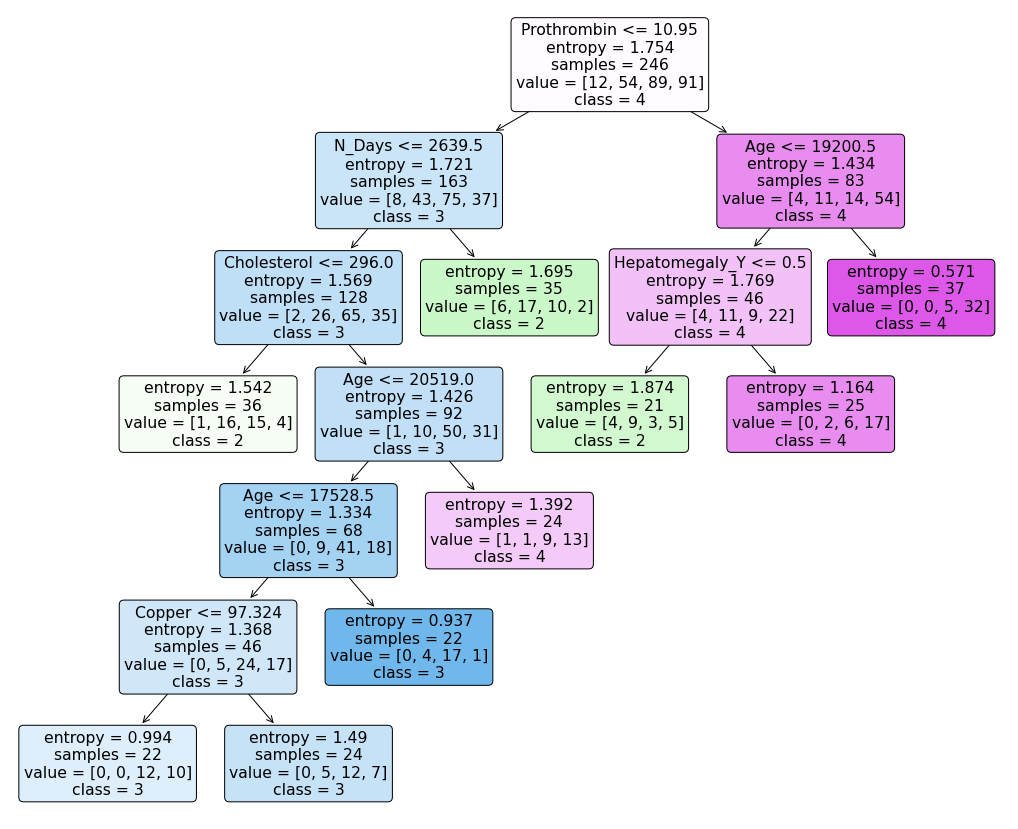

In [215]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=[18, 15])
plot_tree(dt,
          feature_names=feature_names,
          class_names=class_names,
          filled=True, rounded=True)
plt.show()


#### K Vizinhos Próximos

Criámos uma instância do classificador `KNeighborsClassifier` com **10** vizinhos.

Este classificador é sensível à diferença de intervalos. Sem normalização, a coluna *Age* (dezenas de milhar) teria enorme impacto, e a coluna *Bilirubin* (unidades) poderia ser eliminada sem causar diferença.
Para que todas as colunas tenham o mesmo impacto, é necessário normalizar os dados, pelo que recorremos ao `StandardScaler`, normalizando o conjunto de testes e treino.

Avaliando o modelo através de *k-fold cross validation*, podemos concluir que em &asymp;33% das vezes o modelo estará correto.

In [216]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_Xdum = scaler.fit_transform(Xdum)

knn_full = KNeighborsClassifier(n_neighbors=10)
knn_full.fit(standardized_Xdum, y)

KNeighborsClassifier(n_neighbors=10)

In [217]:
scaler = StandardScaler()
standardized_X_train = scaler.fit_transform(X_train)
standardized_X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(standardized_X_train, y_train)

print(f'Precisão teste: {knn.score(standardized_X_test, y_test)}')
print(f'Precisão treino: {knn.score(standardized_X_train, y_train)}')


scores = cross_val_score(knn,
                         X=X_test,
                         y=y_test,
                         cv=5
                         )
print('Precisão Cross Validation k=5:', *scores, sep='\n\t')
print('Precisão média do Cross Validation: %.3f +/- %.3f' %
      (np.mean(scores), np.std(scores)))


Precisão teste: 0.5662650602409639
Precisão treino: 0.5487804878048781
Precisão Cross Validation k=5:
	0.23529411764705882
	0.35294117647058826
	0.23529411764705882
	0.3125
	0.5
Precisão média do Cross Validation: 0.327 +/- 0.098


Ao fazermos o mesmo gráfico que acima sobre a accuracy do modelo obtemos um resultado diferente.

Ao início, em `k` &isin; [1, 6] deparamo-nos com um mau generalizador devido ao ruído/overfit.

Já em `k` &isin; [7, 15] temos um modelo que consegue generalizar, e é o *sweet spot* do valor de `k`. Optámos por escolher `k=10`.

Por fim, chegamos a valores de `k` superiores a 20, o modelo já não consegue generalizar porque as fronteiras deixam de existir

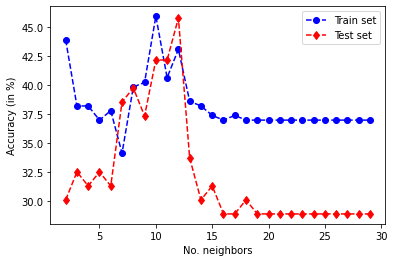

In [218]:
train = []
test = []
rng = list(range(2, 30))

for i in rng:
    ad = KNeighborsClassifier(n_neighbors=i)
    ad.fit(standardized_X_train, y_train)
    train.append(ad.score(X_train, y_train) * 100)
    test.append(ad.score(X_test, y_test) * 100)


plt.plot(rng, train, 'bo--', label='Train set')
plt.plot(rng, test, 'rd--', label='Test set')
plt.xlabel('No. neighbors')
plt.ylabel('Accuracy (in %)')
plt.legend()
plt.show()

Abaixo estão os gráficos de algumas fronteiras

In [219]:
def plot_frontiers_knn(ids, features):
    def _plot_frontiers(X, y, model, feature_names, target_names, nclasses=3, pcolors="ryb"):
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])

        # Plot the training points
        for i, color in zip(range(nclasses), pcolors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                        cmap=plt.cm.RdYlBu, edgecolor='black', s=20)
        plt.legend()

    scaler = StandardScaler()

    small_data = scaler.fit_transform(Xdum[:, ids])
    small_knn = KNeighborsClassifier(n_neighbors=10)
    small_knn.fit(small_data, y)

    _plot_frontiers(small_data,
                    y,
                    small_knn,
                    features,
                    class_names,
                    nclasses=4,
                    pcolors="rybg")


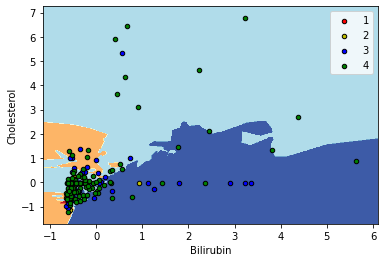

In [220]:

# Bilirubin e Cholesterol
ids = [2, 3]
features = [feature_names[ids[0]], feature_names[ids[1]]]

plot_frontiers_knn(ids, features)

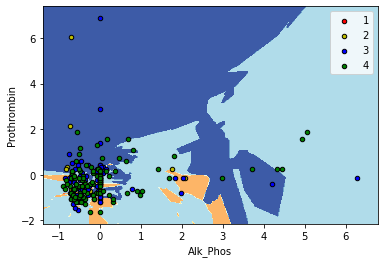

In [221]:
# Alk_Phos e Prothrombin
ids = [6, 10]
features = [feature_names[ids[0]], feature_names[ids[1]]]

plot_frontiers_knn(ids, features)

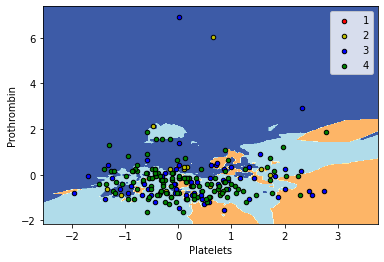

In [222]:
# Platelets e Prothrombin
ids = [9, 10]
features = [feature_names[ids[0]], feature_names[ids[1]]]

plot_frontiers_knn(ids, features)

#### Naïve Bayes

O Naïve Bayes em si não requer parametrização, e depende mais do pré processamento.

Para além de transformar os valores categóricos em numéricos. Algo que poderíamos pegar para melhorar o desempenho do modelo é remover as colunas altamente correlativas, mas isto não se mostrou no dataset (o mais correlativo foi 0.426007 para o *N_Days* e *Bilirubin*).

Houve uma melhoria de 4% ao remover a coluna *Sex*, pois esta não tinha um grande impacto positivo na decisão certa do modelo.

Avaliando o modelo através de *k-fold cross validation*, podemos concluir que em &asymp;40% das vezes o modelo estará correto.

In [223]:
from sklearn.naive_bayes import GaussianNB

nb_full = GaussianNB()
nb_full.fit(Xdum, y)

GaussianNB()

In [224]:
nb = GaussianNB()
nb.fit(X_train, y_train)

print(f'Precisão teste: {knn.score(X_test, y_test)}')
print(f'Precisão treino: {knn.score(X_train, y_train)}')


scores = cross_val_score(nb,
                         X=X_test,
                         y=y_test,
                         cv=5
                         )
print('Precisão Cross Validation k=5:', *scores, sep='\n\t')
print('Precisão média do Cross Validation: %.3f +/- %.3f' %
      (np.mean(scores), np.std(scores)))


Precisão teste: 0.42168674698795183
Precisão treino: 0.45934959349593496
Precisão Cross Validation k=5:
	0.29411764705882354
	0.4117647058823529
	0.29411764705882354
	0.5625
	0.4375
Precisão média do Cross Validation: 0.400 +/- 0.100


### 2.2. Seleção e apresentação do melhor modelo

Escolhemos o classificador Naïve Bayes por ser o que considerámos ser o melhor previsor, de acordo com a validação *k-fold cross validation*.


## 3. Validação do modelo final ajustado com um conjunto de validação independente

In [225]:
Xdum_t, _, feature_names_t, df_cirrose_test = processa_csv('test.csv', tem_y=False)
    
# scaler = StandardScaler()
# scaler.fit(Xdum_t)
# standardized_data_test = scaler.transform(Xdum_t)

# preds = dt_full.predict(Xdum_t)
# preds = knn_full.predict(standardized_data_test)
preds = nb_full.predict(Xdum_t)


df_out = pd.DataFrame({'ID': df_cirrose_test['ID'], 'Stage': preds})
df_out.to_csv('submission.csv', index=False)

## 4. Competição

Mesmo que outros classificadores ou diferenças em parâmetros tenham alcançado um resultado superior na primeira metade da classificação, optámos por escolher o classificador que descrevemos acima 